In [104]:

import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [105]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [106]:

df = pd.read_csv('bank+marketing/bank/bank-full.csv', sep=';')
df['y'] = df['y'].replace({'yes': 1, 'no': 0})

In [107]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


In [108]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [109]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [110]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values


del df_val['y']
del df_test['y']
del df_train['y']

In [111]:
numerical = ['balance','day','duration','previous']

### Question 1: ROC AUC Feature Importance

In [116]:

dv = DictVectorizer(sparse=False)

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

t = 0.5


for item in numerical:
    train_dict = df_train[[item]].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    val_dict = df_val[[item]].to_dict(orient='records')
    X_val = dv.transform(val_dict)

    y_pred = model.predict_proba(X_val)[:, 1]
    churn_decision = (y_pred >= 0.5)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    fpr, tpr, thresholds = roc_curve(y_val, y_pred)
    
    
 
    
    print(item,(y_val == churn_decision).mean(),auc(fpr,tpr))
 


balance 0.878345498783455 0.5995068851725284
day 0.8785666887856669 0.5352198426324892
duration 0.8836540588365406 0.7965344730967409
previous 0.8775713337757134 0.607255799705406


In [119]:
df.dtypes

numerical = ['age','balance','day','duration','campaign','pdays','previous']
categorical = ['job','marital','education','default','housing','loan','contact','month','poutcome']
 

### Question 2: Training the Model

In [121]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
y_decision = (y_pred >= 0.5)
round((y_val == y_decision).mean(),3)

0.898

### Question 3: Precision and Recall

In [122]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [123]:

columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

In [124]:
df_scores

,threshold,tp,fp,fn,tn
0,0.00,1098,7944,0,0
1,0.01,1094,6932,4,1012
2,0.02,1093,5736,5,2208
3,0.03,1085,4671,13,3273
4,0.04,1070,3755,28,4189
...,...,...,...,...,...
96,0.96,33,19,1065,7925
97,0.97,28,14,1070,7930
98,0.98,21,9,1077,7935
99,0.99,11,6,1087,7938


In [125]:
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.fp / (df_scores.fp + df_scores.fn)

In [126]:
df_scores

,threshold,tp,fp,fn,tn,precision,recall
0,0.00,1098,7944,0,0,0.121433,1.000000
1,0.01,1094,6932,4,1012,0.136307,0.999423
2,0.02,1093,5736,5,2208,0.160053,0.999129
3,0.03,1085,4671,13,3273,0.188499,0.997225
4,0.04,1070,3755,28,4189,0.221762,0.992598
...,...,...,...,...,...,...,...
96,0.96,33,19,1065,7925,0.634615,0.017528
97,0.97,28,14,1070,7930,0.666667,0.012915
98,0.98,21,9,1077,7935,0.700000,0.008287
99,0.99,11,6,1087,7938,0.647059,0.005489


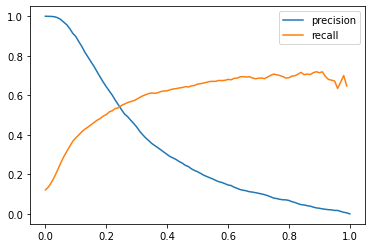

In [127]:
plt.plot(df_scores.threshold, df_scores['recall'], label='precision')
plt.plot(df_scores.threshold, df_scores['precision'], label='recall')
plt.legend()

In [128]:
df_scores[19:30]

,threshold,tp,fp,fn,tn,precision,recall
19,0.19,727,742,371,7202,0.494894,0.666667
20,0.20,709,702,389,7242,0.502481,0.643446
21,0.21,699,655,399,7289,0.516248,0.621442
22,0.22,682,624,416,7320,0.522205,0.600000
23,0.23,666,583,432,7361,0.533227,0.574384
24,0.24,645,556,453,7388,0.537052,0.551041
25,0.25,632,520,466,7424,0.548611,0.527383
26,0.26,616,492,482,7452,0.555957,0.505133
27,0.27,610,473,488,7471,0.563250,0.492196
28,0.28,596,453,502,7491,0.568160,0.474346


### Question 4: F1 Score

In [129]:
df_scores['f1'] = 2*(df_scores.precision*df_scores.recall)/(df_scores.precision+df_scores.recall)

In [130]:
df_scores

,threshold,tp,fp,fn,tn,precision,recall,f1
0,0.00,1098,7944,0,0,0.121433,1.000000,0.216568
1,0.01,1094,6932,4,1012,0.136307,0.999423,0.239896
2,0.02,1093,5736,5,2208,0.160053,0.999129,0.275907
3,0.03,1085,4671,13,3273,0.188499,0.997225,0.317065
4,0.04,1070,3755,28,4189,0.221762,0.992598,0.362529
...,...,...,...,...,...,...,...,...
96,0.96,33,19,1065,7925,0.634615,0.017528,0.034113
97,0.97,28,14,1070,7930,0.666667,0.012915,0.025339
98,0.98,21,9,1077,7935,0.700000,0.008287,0.016381
99,0.99,11,6,1087,7938,0.647059,0.005489,0.010887


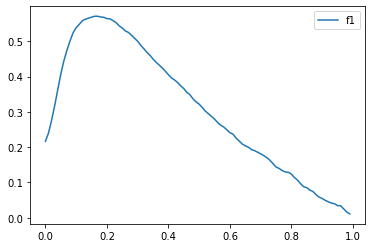

In [131]:
plt.plot(df_scores.threshold, df_scores['f1'], label='f1')
plt.legend()

### Question 5: KFold Cross Validation

In [134]:
from sklearn.model_selection import KFold

In [136]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
print(kf)

KFold(n_splits=5, random_state=1, shuffle=True)


In [157]:
lr=LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [166]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)



In [162]:
df_full_train = df_train+df_val
y_full = df_full_train.y.values

In [163]:
del df_full_train['y']

In [164]:

from sklearn.model_selection import cross_val_score 
scores = cross_val_score(lr, df_full_train, y_full, cv=kf, scoring='r2')

/Users/xydagapito/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/xydagapito/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/xydagapito/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1508, in fit
    X, y = self._validate_data(
  File "/Users/xydagapito/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 581, in _validate_data
    X, y = 

In [153]:
y_full = df['y']

In [154]:
y_full

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: y, Length: 45211, dtype: int64

In [150]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [151]:
y_val

array([0, 0, 0, ..., 0, 0, 0])